In [ ]:
import warnings

def custom_warn(message, category, filename, lineno, file=None, line=None):
    print(f'[{category.__name__}] {filename}:{lineno} --> {message}', flush=True)
warnings.showwarning = custom_warn


### Porting to Google Colab
The following cell enables this notebook to run from Google Colab as well as from your local machine IDE.<br>
You can change `root_directory` and/or `this_notebook_google_path` to point to the directory in your Google account, which contains this notebook, together with the `imgs` sub-directory and the rest of the files.<br>

In [1]:
import sys
import os
try:
    from google.colab import drive as google_drive
except:
    # no Google Colab --> fall back to local machine
    google_drive = None

if google_drive is not None:
    google_drive_directory = os.path.join('/','content','gdrive')
    google_drive.mount(google_drive_directory)
    all_projects_path = os.path.join(google_drive_directory, 'Othercomputers','My Laptop', 'projects')
else:
    all_projects_path = os.path.join('d:\\', 'projects')

project_path = os.path.join(all_projects_path,'BioTAU','Huntington')
assert os.path.exists(project_path), f'Project path {project_path} not found!'
# enable import python files from this notebook's path
sys.path.append(project_path)
# enable reading images and data files from this notebook's path
os.chdir(project_path)

datasets_path = os.path.join(project_path, 'datasets')
assert os.path.exists(datasets_path), f'Datasets path {datasets_path} not found!'

output_path = os.path.join(project_path, 'output')
os.makedirs(output_path, exist_ok=True)
assert os.path.exists(output_path), f'Output path {output_path} not found!'

print(f'Current working directory: {os.getcwd()}')
print(f'Datasets path: {datasets_path}')
print(f'Output path: {output_path}')

Current working directory: d:\projects\BioTAU\Huntington
Datasets path: d:\projects\BioTAU\Huntington\datasets
Output path: d:\projects\BioTAU\Huntington\output


In [2]:
try:
    del python
except:
    pass
if 'python' in sys.modules:
    del sys.modules['python']
try:
    del python.csv_pd
except:
    pass
if 'python.csv_pd' in sys.modules:
    del sys.modules['python.csv_pd']

from python.csv_pd import pd_display, csv_raw_data, csv_header_body_2_dataframe

# Raw file names

In [3]:
file_name_fibro1_well_summary = os.path.join(datasets_path,'Actin_Cap', 'Fibro1.xlsx - Well summary.csv')
file_name_fibro1_block_summary = os.path.join(datasets_path,'Actin_Cap','Fibro1.xlsx - Block summary.csv')
file_name_fibro1_Nuc_cell_TMRE_MITOTRACKER = os.path.join(datasets_path,'Actin_Cap','Fibro1.xlsx - Nuc_cell_TMRE_MITOTRACKER.csv')

file_name_fibro2_well_summary = os.path.join(datasets_path,'Actin_Cap','Fibro2.xlsx - Well summary.csv')
file_name_fibro2_block_summary = os.path.join(datasets_path,'Actin_Cap','Fibro2.xlsx - Block summary.csv')
file_name_fibro2_Nuc_cell_TMRE_MITOTRACKER = os.path.join(datasets_path,'Actin_Cap','Fibro2.xlsx - Nuc_cell_TMRE_MITOTRACKER.csv')

file_name_fibro3_well_summary = os.path.join(datasets_path,'Actin_Cap','Fibro3.xlsx - Well summary.csv')
file_name_fibro3_block_summary = os.path.join(datasets_path,'Actin_Cap','Fibro3.xlsx - Block summary.csv')
file_name_fibro3_Nuc_cell_TMRE_MITOTRACKER = os.path.join(datasets_path,'Actin_Cap','Fibro3.xlsx - Nuc_cell_TMRE_MITOTRACKER.csv')

file_name_patients = os.path.join(datasets_path, 'Actin_Cap','Plates maps.xlsx - Sheet1.csv')

# Preprocess csv files:

In [4]:
import numpy as np

class Fibro_Data_Reader:
    def __init__(self, file_name_well_summary: str, file_name_block_summary: str, file_name_Nuc_cell: str) -> None:
        raw_csv_fibro_well_summary = csv_raw_data(file_name_well_summary)
        well_summary_columns, well_summary_body = Fibro_Data_Reader.get_header4_body(raw_csv_fibro_well_summary)
        self.well_summary = csv_header_body_2_dataframe(header=well_summary_columns, body=well_summary_body)

        raw_csv_fibro_block_summary = csv_raw_data(file_name_block_summary)
        block_summary_columns, block_summary_body = Fibro_Data_Reader.get_header4_body(raw_csv_fibro_block_summary)
        self.block_summary = csv_header_body_2_dataframe(header=block_summary_columns, body=block_summary_body)

        raw_csv_fibro_Nuc_cell_TMRE_MITOTRACKER = csv_raw_data(file_name_Nuc_cell)
        nuc_cell_columns, nuc_cell_body = Fibro_Data_Reader.get_header2_body(raw_csv_fibro_Nuc_cell_TMRE_MITOTRACKER)
        self.nuc_cell = csv_header_body_2_dataframe(header=nuc_cell_columns, body=nuc_cell_body, verbose=False)
        nuc_cell_wells = []
        nuc_cell_columns = []
        for sect in self.nuc_cell['Section'].values:
            sect = sect.strip().split(' ')
            nuc_cell_wells.append(sect[0])
            nuc_cell_columns.append(int(sect[2]))
        self.nuc_cell['Well'] = nuc_cell_wells
        self.nuc_cell['Column'] = np.array(nuc_cell_columns).astype(np.int32)
        display(self.nuc_cell.head())


    @staticmethod
    def remove_column_1(raw_csv: list[list[str]]) -> list[list[str]]:
        return [[row[0]] + row[2:] for row in raw_csv]

    @staticmethod
    def skip_bad_rows(raw_csv: list[list[str]], num_columns: int, first_excel_row: int, verbose: bool = False) -> list[list[str]]:
        count_bad_rows = 0
        res = []
        for excel_row, row in enumerate(raw_csv, start=first_excel_row):
            count_empty = sum(1 for cell in row if not cell)
            if len(row) != num_columns or count_empty:
                if verbose:
                    print(f'Skip excel row[{excel_row}] = empty cells: {count_empty} out of {num_columns}')
                count_bad_rows += 1
                continue
            res.append(row)
        if count_bad_rows:
            print(f'Skiped {count_bad_rows} rows out of {len(raw_csv)} original rows')
        return res

    @staticmethod
    def get_header4_body(raw_csv: list[list[str]]) -> tuple[list[str], list[list[str]]]:
        header = [raw_csv[3][0]] + [f'{row1}_{row2}' for row1,row2 in zip(raw_csv[1][2:],raw_csv[2][2:])]
        body = Fibro_Data_Reader.remove_column_1(raw_csv[4:])
        body = Fibro_Data_Reader.skip_bad_rows(body, len(header), 5)
        return header, body

    @staticmethod
    def get_header2_body(raw_csv: list[list[str]]) -> tuple[list[str], list[list[str]]]:
        header = [raw_csv[1][0]] + [f'{row1}_{row2}' for row1,row2 in zip(raw_csv[0][2:],raw_csv[1][2:])]
        body = Fibro_Data_Reader.remove_column_1(raw_csv[2:])
        body = Fibro_Data_Reader.skip_bad_rows(body, len(header), 3)
        return header, body



In [5]:
fibro1 = Fibro_Data_Reader(file_name_fibro1_well_summary, file_name_fibro1_block_summary, file_name_fibro1_Nuc_cell_TMRE_MITOTRACKER)
fibro2 = Fibro_Data_Reader(file_name_fibro2_well_summary, file_name_fibro2_block_summary, file_name_fibro2_Nuc_cell_TMRE_MITOTRACKER)
fibro3 = Fibro_Data_Reader(file_name_fibro3_well_summary, file_name_fibro3_block_summary, file_name_fibro3_Nuc_cell_TMRE_MITOTRACKER)

Done reading raw csv file: d:\projects\BioTAU\Huntington\datasets\Actin_Cap\Fibro1.xlsx - Well summary.csv into 64 rows and 40 columns
1 Integers columns: ['Ch_1_CELL_COUNT']
37 Float columns: ['Ch_1_NUCLEAR_AREA_MEAN', 'Ch_1_NUCLEAR_DXA_MEAN', 'Ch_1_NUCLEAR_FORM_FACTOR_MEAN', 'Ch_1_NUCLEAR_INTENSITIY_MEAN', 'Ch_1_NUCLEAR_PARIMETER_MEAN', 'Ch_1_NUCLEAR_WRMI_MEAN', 'Ch_1_median_NUCLEAR_AREA', 'Ch_1_median_NUCLEAR_DXA', 'Ch_1_median_NUCLEAR_INTENSITY', 'Ch_1_median_NUCLEAR_PARIMETER', 'Ch_1_median_NUCLEAR_WRMI', 'Ch_2_CELL_AREA_MEAN', 'Ch_2_CELL_DXA_MEAN', 'Ch_2_CELL_FORM_FACTOR_MEAN', 'Ch_2_CELL_INTINSITY_MEAN', 'Ch_2_CELL_PARIEMETER_MEAN', 'Ch_2_median_CELL_AREA', 'Ch_2_median_CELL_DXA', 'Ch_2_median_CELL_FORM_FACTOR', 'Ch_2_median_CELL_INTINSITY', 'Ch_2_median_CELL_PARIMETER', 'Ch_3_MITOTRACKER_AREA', 'Ch_3_MITOTRACKER_DXA_MEAN', 'Ch_3_MITOTRACKER_FORM_FACTOR_MEAN', 'Ch_3_MITOTRACKER_INTENSITY_MEAN', 'Ch_3_median_MITO_AREA', 'Ch_3_median_MITO_DXA', 'Ch_3_median_MITO_FORM_FACTOR', 'Ch_

,Section,Ch_1_CELL_COUNT,Ch_1_NUCLEAR_AREA_MEAN,Ch_1_NUCLEAR_DXA_MEAN,Ch_1_NUCLEAR_FORM_FACTOR_MEAN,Ch_1_NUCLEAR_INTENSITIY_MEAN,Ch_1_NUCLEAR_PARIMETER_MEAN,Ch_1_NUCLEAR_WRMI_MEAN,Ch_1_median_NUCLEAR_AREA,Ch_1_median_NUCLEAR_DXA,...,Ch_3_median_MITO_FORM_FACTOR,Ch_3_median_MITO_INTENSITY,Ch_4_TMRE_AREA_MEAN,Ch_4_TMRE_DXA_MEAN,Ch_4_TMRE_FORM_FACTOR_MEAN,Ch_4_TMRE_INTENSITY_MEAN,Ch_4_median_TMRE_AREA,Ch_4_median_TMRE_DXA,Ch_4_median_TMRE_FORM_FACTOR,Ch_4_median_TMRE_INTENSITY
0,B - 2,136,223.707,148959.8438,0.8827,661.649,56.106,1.024,225.354,134630.9062,...,0.818,56010.0039,411.593,1.6207e+06,0.859,333324.0000,419.073,1.5459e+06,0.862,274785.5625
1,B - 3,96,218.848,131200.5938,0.8830,595.701,56.446,1.084,226.886,128171.3125,...,0.815,68767.8281,210.482,1.2317e+06,0.883,404257.3750,204.440,1.2425e+06,0.891,339138.5625
2,B - 4,121,224.076,163783.1719,0.9112,740.153,55.284,0.994,222.661,136176.0156,...,0.819,39849.4844,263.956,1.0802e+06,0.835,258652.4844,260.475,1.0654e+06,0.835,235637.8594
3,B - 5,112,217.310,139688.9688,0.8800,642.848,55.605,1.026,219.703,129224.1953,...,0.854,61575.7305,387.021,1.4582e+06,0.852,310330.2500,370.221,1.3310e+06,0.852,261675.9531
4,B - 6,170,210.111,156081.4688,0.8959,758.840,54.036,0.998,211.464,140604.1875,...,0.801,30224.3496,291.968,9.7532e+05,0.847,205672.5625,277.323,8.9878e+05,0.843,178697.8594


Done reading raw csv file: d:\projects\BioTAU\Huntington\datasets\Actin_Cap\Fibro1.xlsx - Block summary.csv into 544 rows and 40 columns
Skiped 41 rows out of 540 original rows
1 Integers columns: ['Ch_1_CELL_COUNT']
37 Float columns: ['Ch_1_NUCLEAR_AREA_MEAN', 'Ch_1_NUCLEAR_DXA_MEAN', 'Ch_1_NUCLEAR_FORM_FACTOR_MEAN', 'Ch_1_NUCLEAR_INTENSITIY_MEAN', 'Ch_1_NUCLEAR_PARIMETER_MEAN', 'Ch_1_NUCLEAR_WRMI_MEAN', 'Ch_1_median_NUCLEAR_AREA', 'Ch_1_median_NUCLEAR_DXA', 'Ch_1_median_NUCLEAR_INTENSITY', 'Ch_1_median_NUCLEAR_PARIMETER', 'Ch_1_median_NUCLEAR_WRMI', 'Ch_2_CELL_AREA_MEAN', 'Ch_2_CELL_DXA_MEAN', 'Ch_2_CELL_FORM_FACTOR_MEAN', 'Ch_2_CELL_INTINSITY_MEAN', 'Ch_2_CELL_PARIEMETER_MEAN', 'Ch_2_median_CELL_AREA', 'Ch_2_median_CELL_DXA', 'Ch_2_median_CELL_FORM_FACTOR', 'Ch_2_median_CELL_INTINSITY', 'Ch_2_median_CELL_PARIMETER', 'Ch_3_MITOTRACKER_AREA', 'Ch_3_MITOTRACKER_DXA_MEAN', 'Ch_3_MITOTRACKER_FORM_FACTOR_MEAN', 'Ch_3_MITOTRACKER_INTENSITY_MEAN', 'Ch_3_median_MITO_AREA', 'Ch_3_median_MITO_

,Section,Ch_1_CELL_COUNT,Ch_1_NUCLEAR_AREA_MEAN,Ch_1_NUCLEAR_DXA_MEAN,Ch_1_NUCLEAR_FORM_FACTOR_MEAN,Ch_1_NUCLEAR_INTENSITIY_MEAN,Ch_1_NUCLEAR_PARIMETER_MEAN,Ch_1_NUCLEAR_WRMI_MEAN,Ch_1_median_NUCLEAR_AREA,Ch_1_median_NUCLEAR_DXA,...,Ch_3_median_MITO_FORM_FACTOR,Ch_3_median_MITO_INTENSITY,Ch_4_TMRE_AREA_MEAN,Ch_4_TMRE_DXA_MEAN,Ch_4_TMRE_FORM_FACTOR_MEAN,Ch_4_TMRE_INTENSITY_MEAN,Ch_4_median_TMRE_AREA,Ch_4_median_TMRE_DXA,Ch_4_median_TMRE_FORM_FACTOR,Ch_4_median_TMRE_INTENSITY
0,B - 2 (fld 1),21,197.552,133113.1875,0.9060,696.144,51.770,0.978,189.388,121894.1328,...,0.850,36852.5898,414.252,1.7308e+06,0.872,253913.9375,371.911,1.3949e+06,0.869,207720.0938
1,B - 2 (fld 2),15,219.696,143767.3125,0.8853,670.965,55.182,0.962,243.152,140328.9375,...,0.800,39378.6914,354.349,1.3546e+06,0.868,277466.5312,328.921,1.2888e+06,0.882,252109.2656
2,B - 2 (fld 3),15,232.787,170775.3594,0.8536,719.588,58.601,1.058,221.816,200108.2969,...,0.781,62252.5000,396.924,1.5285e+06,0.842,303965.0938,419.971,1.4421e+06,0.845,304223.4375
3,B - 2 (fld 4),12,242.457,149536.9219,0.8739,595.127,58.911,1.091,227.625,132864.2969,...,0.828,89201.7969,487.520,1.8394e+06,0.863,452623.1250,487.731,1.8277e+06,0.863,288661.7188
4,B - 2 (fld 5),16,219.492,148465.4531,0.8661,651.114,56.295,1.049,218.858,134957.3438,...,0.855,19419.4004,378.618,1.4908e+06,0.858,250642.4844,417.489,1.5594e+06,0.853,231025.0312


Done reading raw csv file: d:\projects\BioTAU\Huntington\datasets\Actin_Cap\Fibro1.xlsx - Nuc_cell_TMRE_MITOTRACKER.csv into 4858 rows and 43 columns


,Section,Ch_4_TMRE_AREA,Ch_4_TMRE_POS_X,Ch_4_TMRE_POS_Y,Ch_4_TMRE_INTENSITY,Ch_4_TMRE_FORM_FACTOR,Ch_4_TMRE_COUNT,Ch_4_TMRE_DxA,Ch_4_TMRE_AREA_AVG,Ch_3_MITOTRECKER_AREA,...,Ch_2_CELL_END_NODES,Ch_2_CELL_PARIEMETER,Ch_2_CELL_AVG__DIAMETER,Ch_2_CELL_MED_DIAMETER,Ch_2_CELL_FRMI,Ch_2_CELL_LENGTH,Ch_2_CELL_CROSSING_POINTS,Ch_2_CELL_BRANCH_NODES,Well,Column
0,B - 2 (fld 1),371.911,24691.5605,31495.2852,207720.0938,0.909,55,1.3949e+06,6.762,986.5520,...,13,309.943,11.231,5.695,0.817,130.205,1,10,B,2
1,B - 2 (fld 1),622.457,61400.9375,105458.3672,710594.1875,0.914,200,2.3754e+06,3.112,1985.3571,...,40,703.398,29.043,28.092,1.235,200.438,2,33,B,2
2,B - 2 (fld 1),140.378,21717.7109,23164.1328,134572.1719,0.898,42,4.8409e+05,3.342,483.4530,...,23,360.530,21.138,25.827,0.991,107.069,1,19,B,2
3,B - 2 (fld 1),167.101,16675.0586,14438.2617,92862.6406,0.829,27,6.1080e+05,6.189,625.0980,...,26,284.333,35.132,36.081,0.921,83.814,2,20,B,2
4,B - 2 (fld 1),465.919,14379.1904,58880.2031,405854.7812,0.871,115,1.9123e+06,4.051,1470.7450,...,27,449.256,13.666,8.282,0.851,126.103,1,21,B,2


Done reading raw csv file: d:\projects\BioTAU\Huntington\datasets\Actin_Cap\Fibro2.xlsx - Well summary.csv into 64 rows and 40 columns
1 Integers columns: ['Ch_1_CELL_COUNT']
37 Float columns: ['Ch_1_NUCLEAR_AREA_MEAN', 'Ch_1_NUCLEAR_DXA_MEAN', 'Ch_1_NUCLEAR_FORM_FACTOR_MEAN', 'Ch_1_NUCLEAR_INTENSITIY_MEAN', 'Ch_1_NUCLEAR_PARIMETER_MEAN', 'Ch_1_NUCLEAR_WRMI_MEAN', 'Ch_1_median_NUCLEAR_AREA', 'Ch_1_median_NUCLEAR_DXA', 'Ch_1_median_NUCLEAR_INTENSITY', 'Ch_1_median_NUCLEAR_PARIMETER', 'Ch_1_median_NUCLEAR_WRMI', 'Ch_2_CELL_AREA_MEAN', 'Ch_2_CELL_DXA_MEAN', 'Ch_2_CELL_FORM_FACTOR_MEAN', 'Ch_2_CELL_INTINSITY_MEAN', 'Ch_2_CELL_PARIEMETER_MEAN', 'Ch_2_median_CELL_AREA', 'Ch_2_median_CELL_DXA', 'Ch_2_median_CELL_FORM_FACTOR', 'Ch_2_median_CELL_INTINSITY', 'Ch_2_median_CELL_PARIMETER', 'Ch_3_MITOTRACKER_AREA', 'Ch_3_MITOTRACKER_DXA_MEAN', 'Ch_3_MITOTRACKER_FORM_FACTOR_MEAN', 'Ch_3_MITOTRACKER_INTENSITY_MEAN', 'Ch_3_median_MITO_AREA', 'Ch_3_median_MITO_DXA', 'Ch_3_median_MITO_FORM_FACTOR', 'Ch_

,Section,Ch_1_CELL_COUNT,Ch_1_NUCLEAR_AREA_MEAN,Ch_1_NUCLEAR_DXA_MEAN,Ch_1_NUCLEAR_FORM_FACTOR_MEAN,Ch_1_NUCLEAR_INTENSITIY_MEAN,Ch_1_NUCLEAR_PARIMETER_MEAN,Ch_1_NUCLEAR_WRMI_MEAN,Ch_1_median_NUCLEAR_AREA,Ch_1_median_NUCLEAR_DXA,...,Ch_3_median_MITO_FORM_FACTOR,Ch_3_median_MITO_INTENSITY,Ch_4_TMRE_AREA_MEAN,Ch_4_TMRE_DXA_MEAN,Ch_4_TMRE_FORM_FACTOR_MEAN,Ch_4_TMRE_INTENSITY_MEAN,Ch_4_median_TMRE_AREA,Ch_4_median_TMRE_DXA,Ch_4_median_TMRE_FORM_FACTOR,Ch_4_median_TMRE_INTENSITY
0,B - 2,116,255.043,174032.4062,0.9021,683.687,59.328,1.003,241.938,152607.2344,...,0.848,76579.6797,212.018,7.9870e+05,0.869,283238.1562,198.420,7.3661e+05,0.877,260000.6719
1,B - 3,96,254.754,161851.0781,0.9199,637.587,58.692,0.988,239.191,136267.3750,...,0.839,66605.1484,247.347,9.6165e+05,0.853,287844.7188,231.481,8.7151e+05,0.853,230063.3594
2,B - 4,110,266.382,180239.7344,0.8942,684.040,60.883,1.016,254.983,180506.0625,...,0.880,70417.4297,281.446,1.0356e+06,0.869,262520.4062,257.676,8.9819e+05,0.865,209193.2344
3,B - 5,91,264.973,152498.9531,0.8860,573.191,60.783,1.021,262.060,137560.7812,...,0.847,135437.6875,335.897,1.1779e+06,0.865,384332.7188,313.922,1.0941e+06,0.866,325337.8438
4,B - 6,99,229.885,174758.0625,0.9106,754.579,56.147,1.003,222.872,174747.0312,...,0.852,68294.0234,366.069,9.3011e+05,0.855,225648.8125,352.370,8.7774e+05,0.854,208217.0938


Done reading raw csv file: d:\projects\BioTAU\Huntington\datasets\Actin_Cap\Fibro2.xlsx - Block summary.csv into 544 rows and 40 columns
Skiped 22 rows out of 540 original rows
1 Integers columns: ['Ch_1_CELL_COUNT']
37 Float columns: ['Ch_1_NUCLEAR_AREA_MEAN', 'Ch_1_NUCLEAR_DXA_MEAN', 'Ch_1_NUCLEAR_FORM_FACTOR_MEAN', 'Ch_1_NUCLEAR_INTENSITIY_MEAN', 'Ch_1_NUCLEAR_PARIMETER_MEAN', 'Ch_1_NUCLEAR_WRMI_MEAN', 'Ch_1_median_NUCLEAR_AREA', 'Ch_1_median_NUCLEAR_DXA', 'Ch_1_median_NUCLEAR_INTENSITY', 'Ch_1_median_NUCLEAR_PARIMETER', 'Ch_1_median_NUCLEAR_WRMI', 'Ch_2_CELL_AREA_MEAN', 'Ch_2_CELL_DXA_MEAN', 'Ch_2_CELL_FORM_FACTOR_MEAN', 'Ch_2_CELL_INTINSITY_MEAN', 'Ch_2_CELL_PARIEMETER_MEAN', 'Ch_2_median_CELL_AREA', 'Ch_2_median_CELL_DXA', 'Ch_2_median_CELL_FORM_FACTOR', 'Ch_2_median_CELL_INTINSITY', 'Ch_2_median_CELL_PARIMETER', 'Ch_3_MITOTRACKER_AREA', 'Ch_3_MITOTRACKER_DXA_MEAN', 'Ch_3_MITOTRACKER_FORM_FACTOR_MEAN', 'Ch_3_MITOTRACKER_INTENSITY_MEAN', 'Ch_3_median_MITO_AREA', 'Ch_3_median_MITO_

,Section,Ch_1_CELL_COUNT,Ch_1_NUCLEAR_AREA_MEAN,Ch_1_NUCLEAR_DXA_MEAN,Ch_1_NUCLEAR_FORM_FACTOR_MEAN,Ch_1_NUCLEAR_INTENSITIY_MEAN,Ch_1_NUCLEAR_PARIMETER_MEAN,Ch_1_NUCLEAR_WRMI_MEAN,Ch_1_median_NUCLEAR_AREA,Ch_1_median_NUCLEAR_DXA,...,Ch_3_median_MITO_FORM_FACTOR,Ch_3_median_MITO_INTENSITY,Ch_4_TMRE_AREA_MEAN,Ch_4_TMRE_DXA_MEAN,Ch_4_TMRE_FORM_FACTOR_MEAN,Ch_4_TMRE_INTENSITY_MEAN,Ch_4_median_TMRE_AREA,Ch_4_median_TMRE_DXA,Ch_4_median_TMRE_FORM_FACTOR,Ch_4_median_TMRE_INTENSITY
0,B - 2 (fld 1),19,242.230,172069.0156,0.8916,710.448,58.217,1.008,239.561,149444.4062,...,0.837,49156.9062,181.806,711337.1250,0.852,233198.6719,170.693,660815.0000,0.841,235219.3906
1,B - 2 (fld 2),14,245.718,159441.6406,0.9154,657.422,57.960,0.990,243.416,137801.4375,...,0.837,75240.4062,232.213,891527.5000,0.866,315871.3438,207.662,803208.8750,0.864,302654.4062
2,B - 2 (fld 3),14,292.631,202167.7812,0.9119,676.183,63.007,0.982,266.760,198659.6250,...,0.817,97925.0781,239.682,872838.6250,0.879,339708.1250,210.303,740056.4375,0.885,300679.0938
3,B - 2 (fld 4),8,239.350,159230.7656,0.9044,664.829,57.409,0.992,233.540,143880.4688,...,0.870,129949.6172,246.849,896731.8750,0.890,341614.5000,214.528,768765.4375,0.898,322818.0938
4,B - 2 (fld 5),13,248.702,157322.5625,0.8937,638.366,59.021,1.012,238.399,135742.6250,...,0.848,76438.3516,222.303,840758.3125,0.858,297398.1250,212.732,763564.2500,0.877,298697.7188


Done reading raw csv file: d:\projects\BioTAU\Huntington\datasets\Actin_Cap\Fibro2.xlsx - Nuc_cell_TMRE_MITOTRACKER.csv into 5362 rows and 43 columns


,Section,Ch_4_TMRE_AREA,Ch_4_TMRE_POS_X,Ch_4_TMRE_POS_Y,Ch_4_TMRE_INTENSITY,Ch_4_TMRE_FORM_FACTOR,Ch_4_TMRE_COUNT,Ch_4_TMRE_DxA,Ch_4_TMRE_AREA_AVG,Ch_3_MITOTRECKER_AREA,...,Ch_2_CELL_END_NODES,Ch_2_CELL_PARIEMETER,Ch_2_CELL_AVG__DIAMETER,Ch_2_CELL_MED_DIAMETER,Ch_2_CELL_FRMI,Ch_2_CELL_LENGTH,Ch_2_CELL_CROSSING_POINTS,Ch_2_CELL_BRANCH_NODES,Well,Column
0,B - 2 (fld 1),126.118,17160.1191,31388.6816,186617.8906,0.882,55,456360.7188,2.293,911.241,...,26,546.604,13.325,5.695,0.598,142.428,2,18,B,2
1,B - 2 (fld 1),188.755,21657.9160,52884.7930,353473.4688,0.917,93,737280.3125,2.030,1081.933,...,29,554.673,13.912,11.036,0.800,213.654,2,25,B,2
2,B - 2 (fld 1),144.708,31255.5156,28180.6543,175006.2656,0.897,51,513372.7812,2.837,781.954,...,27,556.026,11.495,9.957,0.909,161.380,3,17,B,2
3,B - 2 (fld 1),236.075,17178.7402,35074.7148,263653.5000,0.777,70,991699.8125,3.373,835.084,...,13,400.548,10.741,8.464,1.039,165.625,4,3,B,2
4,B - 2 (fld 1),219.598,20041.1055,31547.0684,244647.7344,0.817,66,866203.8125,3.327,777.834,...,12,477.330,9.524,10.613,1.245,207.035,0,8,B,2


Done reading raw csv file: d:\projects\BioTAU\Huntington\datasets\Actin_Cap\Fibro3.xlsx - Well summary.csv into 64 rows and 40 columns
1 Integers columns: ['Ch_1_CELL_COUNT']
37 Float columns: ['Ch_1_NUCLEAR_AREA_MEAN', 'Ch_1_NUCLEAR_DXA_MEAN', 'Ch_1_NUCLEAR_FORM_FACTOR_MEAN', 'Ch_1_NUCLEAR_INTENSITIY_MEAN', 'Ch_1_NUCLEAR_PARIMETER_MEAN', 'Ch_1_NUCLEAR_WRMI_MEAN', 'Ch_1_median_NUCLEAR_AREA', 'Ch_1_median_NUCLEAR_DXA', 'Ch_1_median_NUCLEAR_INTENSITY', 'Ch_1_median_NUCLEAR_PARIMETER', 'Ch_1_median_NUCLEAR_WRMI', 'Ch_2_CELL_AREA_MEAN', 'Ch_2_CELL_DXA_MEAN', 'Ch_2_CELL_FORM_FACTOR_MEAN', 'Ch_2_CELL_INTINSITY_MEAN', 'Ch_2_CELL_PARIEMETER_MEAN', 'Ch_2_median_CELL_AREA', 'Ch_2_median_CELL_DXA', 'Ch_2_median_CELL_FORM_FACTOR', 'Ch_2_median_CELL_INTINSITY', 'Ch_2_median_CELL_PARIMETER', 'Ch_3_MITOTRACKER_AREA', 'Ch_3_MITOTRACKER_DXA_MEAN', 'Ch_3_MITOTRACKER_FORM_FACTOR_MEAN', 'Ch_3_MITOTRACKER_INTENSITY_MEAN', 'Ch_3_median_MITO_AREA', 'Ch_3_median_MITO_DXA', 'Ch_3_median_MITO_FORM_FACTOR', 'Ch_

,Section,Ch_1_CELL_COUNT,Ch_1_NUCLEAR_AREA_MEAN,Ch_1_NUCLEAR_DXA_MEAN,Ch_1_NUCLEAR_FORM_FACTOR_MEAN,Ch_1_NUCLEAR_INTENSITIY_MEAN,Ch_1_NUCLEAR_PARIMETER_MEAN,Ch_1_NUCLEAR_WRMI_MEAN,Ch_1_median_NUCLEAR_AREA,Ch_1_median_NUCLEAR_DXA,...,Ch_3_median_MITO_FORM_FACTOR,Ch_3_median_MITO_INTENSITY,Ch_4_TMRE_AREA_MEAN,Ch_4_TMRE_DXA_MEAN,Ch_4_TMRE_FORM_FACTOR_MEAN,Ch_4_TMRE_INTENSITY_MEAN,Ch_4_median_TMRE_AREA,Ch_4_median_TMRE_DXA,Ch_4_median_TMRE_FORM_FACTOR,Ch_4_median_TMRE_INTENSITY
0,B - 2,40,229.305,90096.5391,0.9024,394.195,56.403,1.052,223.823,90169.2969,...,0.874,138529.5625,408.492,1.6872e+06,0.848,418409.0625,349.360,1.4111e+06,0.855,319750.7188
1,B - 3,79,208.845,81721.9844,0.9020,392.306,53.618,1.026,210.619,82476.9375,...,0.808,144806.4844,693.731,2.7814e+06,0.842,537152.1250,622.880,2.4100e+06,0.844,414749.6562
2,B - 4,56,223.085,90682.3125,0.9187,406.066,55.014,1.036,218.066,91343.2812,...,0.843,130899.0000,257.408,1.1667e+06,0.868,429451.1250,209.986,9.0259e+05,0.872,340164.3750
3,B - 5,57,206.350,88192.7266,0.9313,430.023,52.908,0.995,190.550,84473.1719,...,0.839,108010.4297,361.143,1.8341e+06,0.871,376845.6562,344.131,1.6440e+06,0.875,331427.1250
4,B - 6,67,223.621,81176.4062,0.9098,362.923,55.294,1.028,209.352,81214.4844,...,0.839,56325.2188,362.414,1.0725e+06,0.805,227233.7812,343.815,1.0032e+06,0.810,187233.7656


Done reading raw csv file: d:\projects\BioTAU\Huntington\datasets\Actin_Cap\Fibro3.xlsx - Block summary.csv into 544 rows and 40 columns
Skiped 11 rows out of 540 original rows
1 Integers columns: ['Ch_1_CELL_COUNT']
37 Float columns: ['Ch_1_NUCLEAR_AREA_MEAN', 'Ch_1_NUCLEAR_DXA_MEAN', 'Ch_1_NUCLEAR_FORM_FACTOR_MEAN', 'Ch_1_NUCLEAR_INTENSITIY_MEAN', 'Ch_1_NUCLEAR_PARIMETER_MEAN', 'Ch_1_NUCLEAR_WRMI_MEAN', 'Ch_1_median_NUCLEAR_AREA', 'Ch_1_median_NUCLEAR_DXA', 'Ch_1_median_NUCLEAR_INTENSITY', 'Ch_1_median_NUCLEAR_PARIMETER', 'Ch_1_median_NUCLEAR_WRMI', 'Ch_2_CELL_AREA_MEAN', 'Ch_2_CELL_DXA_MEAN', 'Ch_2_CELL_FORM_FACTOR_MEAN', 'Ch_2_CELL_INTINSITY_MEAN', 'Ch_2_CELL_PARIEMETER_MEAN', 'Ch_2_median_CELL_AREA', 'Ch_2_median_CELL_DXA', 'Ch_2_median_CELL_FORM_FACTOR', 'Ch_2_median_CELL_INTINSITY', 'Ch_2_median_CELL_PARIMETER', 'Ch_3_MITOTRACKER_AREA', 'Ch_3_MITOTRACKER_DXA_MEAN', 'Ch_3_MITOTRACKER_FORM_FACTOR_MEAN', 'Ch_3_MITOTRACKER_INTENSITY_MEAN', 'Ch_3_median_MITO_AREA', 'Ch_3_median_MITO_

,Section,Ch_1_CELL_COUNT,Ch_1_NUCLEAR_AREA_MEAN,Ch_1_NUCLEAR_DXA_MEAN,Ch_1_NUCLEAR_FORM_FACTOR_MEAN,Ch_1_NUCLEAR_INTENSITIY_MEAN,Ch_1_NUCLEAR_PARIMETER_MEAN,Ch_1_NUCLEAR_WRMI_MEAN,Ch_1_median_NUCLEAR_AREA,Ch_1_median_NUCLEAR_DXA,...,Ch_3_median_MITO_FORM_FACTOR,Ch_3_median_MITO_INTENSITY,Ch_4_TMRE_AREA_MEAN,Ch_4_TMRE_DXA_MEAN,Ch_4_TMRE_FORM_FACTOR_MEAN,Ch_4_TMRE_INTENSITY_MEAN,Ch_4_median_TMRE_AREA,Ch_4_median_TMRE_DXA,Ch_4_median_TMRE_FORM_FACTOR,Ch_4_median_TMRE_INTENSITY
0,B - 2 (fld 1),5,232.125,92967.3203,0.9050,401.295,56.524,1.044,229.421,90233.7266,...,0.888,111223.9219,282.509,1.1450e+06,0.853,317870.2812,272.200,9.9747e+05,0.848,314592.3438
1,B - 2 (fld 2),4,230.081,84418.9297,0.8340,369.218,59.182,1.144,236.181,80238.2344,...,0.897,148304.1719,566.396,2.4592e+06,0.867,637721.3750,558.765,2.4828e+06,0.873,432485.2500
2,B - 2 (fld 3),3,230.266,91183.5938,0.9220,396.059,56.026,1.036,224.879,95007.6250,...,0.873,138806.4688,385.115,1.7273e+06,0.837,373227.3750,391.769,1.7835e+06,0.871,348662.7812
3,B - 2 (fld 4),4,228.101,91326.4062,0.8835,397.738,56.632,1.077,216.587,84978.8047,...,0.916,108182.0078,336.843,1.1966e+06,0.850,311200.4062,326.597,1.2165e+06,0.841,312905.8750
4,B - 2 (fld 5),4,210.804,83599.3750,0.9187,395.414,53.646,1.025,209.563,88803.0156,...,0.881,161107.1250,347.353,1.3865e+06,0.873,367083.4375,359.183,1.4318e+06,0.869,332634.0312


Done reading raw csv file: d:\projects\BioTAU\Huntington\datasets\Actin_Cap\Fibro3.xlsx - Nuc_cell_TMRE_MITOTRACKER.csv into 4792 rows and 43 columns


,Section,Ch_4_TMRE_AREA,Ch_4_TMRE_POS_X,Ch_4_TMRE_POS_Y,Ch_4_TMRE_INTENSITY,Ch_4_TMRE_FORM_FACTOR,Ch_4_TMRE_COUNT,Ch_4_TMRE_DxA,Ch_4_TMRE_AREA_AVG,Ch_3_MITOTRECKER_AREA,...,Ch_2_CELL_END_NODES,Ch_2_CELL_PARIEMETER,Ch_2_CELL_AVG__DIAMETER,Ch_2_CELL_MED_DIAMETER,Ch_2_CELL_FRMI,Ch_2_CELL_LENGTH,Ch_2_CELL_CROSSING_POINTS,Ch_2_CELL_BRANCH_NODES,Well,Column
0,B - 2 (fld 1),320.788,26104.3848,36937.3984,280979.2812,0.923,69,1.5472e+06,4.649,792.4110,...,28,380.842,20.225,20.044,0.951,113.247,2,19,B,2
1,B - 2 (fld 1),199.317,7845.6152,17390.2637,140285.3594,0.863,35,8.8909e+05,5.695,1094.8199,...,34,504.640,14.610,16.790,0.956,177.343,3,26,B,2
2,B - 2 (fld 1),363.144,57444.8555,40402.5117,470429.3438,0.804,131,1.4131e+06,2.772,986.7640,...,33,499.135,19.891,20.683,0.681,151.866,1,27,B,2
3,B - 2 (fld 1),257.095,61531.9258,37075.4219,383065.0625,0.848,117,8.7803e+05,2.197,853.8850,...,31,619.344,19.601,10.855,0.889,144.949,1,23,B,2
4,B - 2 (fld 1),272.200,42479.8438,25101.2852,314592.3438,0.824,94,9.9747e+05,2.896,809.8390,...,17,378.058,15.824,11.719,0.568,126.323,2,12,B,2


# Processing main patients table

In [6]:
class Actin_Cap_Figure_1_Patients:
    def __init__(self, file_name: str):
        raw_csv_patients = csv_raw_data(file_name)
        ### preprocess patients
        sub_raw_patients = [raw_csv_patients[0]] + raw_csv_patients[2:12] + raw_csv_patients[13:23] + raw_csv_patients[24:34]
        csv_patients = [row[4:12] for row in sub_raw_patients]
        header = csv_patients[0]
        body = csv_patients[1:]
        df = csv_header_body_2_dataframe(header=header, body=body, rename_header={'SAMPLE TYPE??':'Sample_Type'}, verbose=False)
        fibro_nums = [int(fib[5:7]) for fib in df['Experiment_Number'].values]
        df['Fibro_Num'] = fibro_nums
        column_num = [int(col[6:]) for col in df['Location_in_plate'].values]
        df['Column'] = column_num
        self.df = df.set_index('Sample_ID')
        display(self.df)
        self.fibro_col_num_2_name = {(fib_num,col_num):name for name,fib_num,col_num in zip(self.df.index,fibro_nums,column_num)}



figure_1_patients = Actin_Cap_Figure_1_Patients(file_name_patients)

Done reading raw csv file: d:\projects\BioTAU\Huntington\datasets\Actin_Cap\Plates maps.xlsx - Sheet1.csv into 34 rows and 28 columns


,Sample_Type,Cell_Passage,Age,Gender,Date_of_plating,Experiment_Number,Location_in_plate,Fibro_Num,Column
Sample_ID,,,,,,,,,
NA0579,HC,8,40,M,42771,FIBRO 1 HD,Column 2,1,2
GM04476,HD,9,57,M,42771,FIBRO 1 HD,Column 3,1,3
NA0233,HC,7,61,F,42771,FIBRO 1 HD,Column 4,1,4
NA0351,HC,3,62,M,42771,FIBRO 1 HD,Column 5,1,5
NA0848,HC,9,48,F,42771,FIBRO 1 HD,Column 6,1,6
GM04212,HD,9,50,F,42771,FIBRO 1 HD,Column 7,1,7
NA1170,HC,3,43,M,42771,FIBRO 1 HD,Column 8,1,8
GM02147,HD,7,55,M,42771,FIBRO 1 HD,Column 9,1,9
NA0561,HC,3,48,M,42771,FIBRO 1 HD,Column 10,1,10


# Concats all wells summaries

In [7]:
import pandas as pd
all_well_summaries = [fibro1.well_summary,fibro2.well_summary,fibro3.well_summary]
df_full_wells_summary = pd.concat(all_well_summaries, axis=0, ignore_index=True)
fibro_num = [1]*len(all_well_summaries[0])+[2]*len(all_well_summaries[1])+[3]*len(all_well_summaries[2])
df_full_wells_summary['fibro_num'] = fibro_num
df_full_wells_summary['plate_column'] = df_full_wells_summary['Section'].apply(lambda well_val: int(well_val[3:]))
print(f'df_full_wells_summary.shape={df_full_wells_summary.shape}')
pd_display(df_full_wells_summary.head())

df_full_wells_summary.shape=(180, 41)


,Section,Ch_1_CELL_COUNT,Ch_1_NUCLEAR_AREA_MEAN,Ch_1_NUCLEAR_DXA_MEAN,Ch_1_NUCLEAR_FORM_FACTOR_MEAN,Ch_1_NUCLEAR_INTENSITIY_MEAN,Ch_1_NUCLEAR_PARIMETER_MEAN,Ch_1_NUCLEAR_WRMI_MEAN,Ch_1_median_NUCLEAR_AREA,Ch_1_median_NUCLEAR_DXA,...,Ch_4_TMRE_AREA_MEAN,Ch_4_TMRE_DXA_MEAN,Ch_4_TMRE_FORM_FACTOR_MEAN,Ch_4_TMRE_INTENSITY_MEAN,Ch_4_median_TMRE_AREA,Ch_4_median_TMRE_DXA,Ch_4_median_TMRE_FORM_FACTOR,Ch_4_median_TMRE_INTENSITY,fibro_num,plate_column
0,B - 2,136,223.707,148959.8438,0.8827,661.649,56.106,1.024,225.354,134630.9062,...,411.593,1.6207e+06,0.859,333324.0000,419.073,1.5459e+06,0.862,274785.5625,1,2
1,B - 3,96,218.848,131200.5938,0.8830,595.701,56.446,1.084,226.886,128171.3125,...,210.482,1.2317e+06,0.883,404257.3750,204.440,1.2425e+06,0.891,339138.5625,1,3
2,B - 4,121,224.076,163783.1719,0.9112,740.153,55.284,0.994,222.661,136176.0156,...,263.956,1.0802e+06,0.835,258652.4844,260.475,1.0654e+06,0.835,235637.8594,1,4
3,B - 5,112,217.310,139688.9688,0.8800,642.848,55.605,1.026,219.703,129224.1953,...,387.021,1.4582e+06,0.852,310330.2500,370.221,1.3310e+06,0.852,261675.9531,1,5
4,B - 6,170,210.111,156081.4688,0.8959,758.840,54.036,0.998,211.464,140604.1875,...,291.968,9.7532e+05,0.847,205672.5625,277.323,8.9878e+05,0.843,178697.8594,1,6


# Cell count per patient

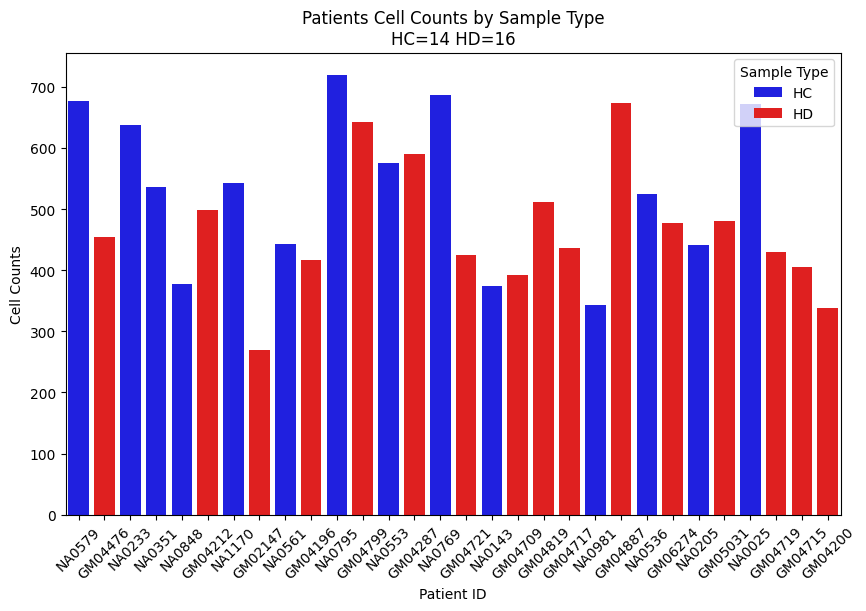

In [8]:
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
patient_cell_count = defaultdict(int)


for index_row, well_summary in df_full_wells_summary.iterrows():
    fib_num = well_summary['fibro_num']
    col = well_summary['plate_column']
    counts = well_summary['Ch_1_CELL_COUNT']
    name = figure_1_patients.fibro_col_num_2_name[(fib_num,col)]
    patient_cell_count[name] += counts

names = patient_cell_count.keys()
patient_cell_count = [patient_cell_count[name] for name in names]
sample_type = [figure_1_patients.df.loc[name]['Sample_Type'] for name in names]
df_cell_count = pd.DataFrame({'Patient ID': names,\
                              'Cell Counts': patient_cell_count,\
                              'Sample Type': sample_type
})

sub_title = []
for samp_type, count in zip(*np.unique(sample_type, return_counts=True)):
    sub_title.append(f'{samp_type}={count}')
sub_title = ' '.join(sub_title)
palette = {'HC': 'blue', 'HD': 'red'}
plt.figure(figsize=(10, 6))
sns.barplot(x='Patient ID', y='Cell Counts', hue='Sample Type', data=df_cell_count, dodge=False, palette=palette)
plt.xticks(rotation=45)
plt.title(f'Patients Cell Counts by Sample Type\n{sub_title}')
plt.xlabel('Patient ID')
plt.ylabel('Cell Counts')
plt.show()

# Build  patients wells

In [9]:
class PatientData:
    def __init__(self, name: str, cell_type: str, age: float, gender: str, passage: int, cag_repeats: int = None, cap_score: float = None):
        self.name = name
        self.cell_type = cell_type
        self.age = age
        self.gender = gender
        self.passage = passage
        self.cap_score = cap_score
        self.cag_repeats = cag_repeats
        self.wells_data = {}
        self.additional_columns = {}
        self.total_rows = 0
        self.df_columns = []

    def collect_data_from_wells(self, df_data: pd.DataFrame, plate_col: int, verbose: bool = False):
        df_data = df_data.drop(['Section'], axis=1)
        df_data = df_data[df_data.pop('Column')==plate_col]
        wells = df_data.pop('Well')
        self.wells_data = {}
        self.total_rows = 0
        for w in wells.unique():
            well_df = df_data[wells==w].copy()
            self.wells_data[w] = well_df
            self.total_rows += len(well_df)
        self.build_additional_columns()
        self.df_columns = next(iter(self.wells_data.values())).columns.tolist()
        self.patient_columns = ['cell_type', 'age', 'gender', 'passage']
        self.cell_type_HD_columns = ['cap_score', 'cag_repeats']
        if verbose:
            print(f'Patient: {self.name}[{self.cell_type}] has {self.total_rows} total rows.')
            print(print(df_data.describe()))
            print()
            columns_near_zero = df_data.columns[df_data.min() < 1e-6]
            if len(columns_near_zero) > 0:
                print(f'Patient {self.name} has zero columns:')
                display(df_data[columns_near_zero].describe())

    def is_cell_type(self, cell_type: str) -> bool:
        return cell_type is None or cell_type.lower() == self.cell_type.lower()

    def collect_single_column(self, col: str) -> np.ndarray:
        col_lower = col.lower()
        if col_lower in self.additional_columns:
            return self.additional_columns[col_lower]
        data_columns = [data[col] for data in self.wells_data.values()]

        assert isinstance(data_columns[0].iloc[0], (int,float,np.int32,np.float32)), f'col_data[{col}][0]={data_columns[0].iloc[0]}  type={type(data_columns[0].iloc[0])}'
        return pd.concat(data_columns).to_numpy()

    def collect_single_column_op(self, op: str, col: str) -> np.ndarray:
        assert isinstance(op, str)
        res = self.collect_single_column(col)
        if op == '*':
            return res.copy().astype(np.float32)
        assert res.min() > 1e-6, f'Column[{col}].min() = {res.min()}'
        if op == '/':
            return (1./res).astype(np.float32)
        if op == 'ln':
            return np.log(res).astype(np.float32)
        assert False, f'collect_single_column_op(op={op})'

    def collect_column_recipe(self, col_recipe: str|list[str]) -> np.ndarray:
        if isinstance(col_recipe, str):
            return self.collect_single_column(col_recipe).copy().astype(np.float32)
        result = self.collect_single_column_op(col_recipe[0],col_recipe[1])
        for i_col in range(2,len(col_recipe),2):
            result *= self.collect_single_column_op(col_recipe[i_col],col_recipe[i_col+1])
        return result

    def remove_columns(self, columns_to_remove: list[str]) -> None:
        for w in self.wells_data.keys():
            self.wells_data[w] = self.wells_data[w].drop(columns=columns_to_remove)
        self.df_columns = next(iter(self.wells_data.values())).columns.tolist()

    def remove_rows_non_positive(self) -> None:
        self.total_rows = 0
        for w, data in self.wells_data.items():
            rows_to_keep = np.ones(len(data), dtype=bool)
            for col in data.columns:
                rows_to_keep &= data[col].values >= 1e-6
            data = data[rows_to_keep].reset_index(drop=True)
            self.wells_data[w] = data
            self.total_rows += len(data)
        self.build_additional_columns() # changed number of rows

    def build_additional_columns(self) -> None:
        self.additional_columns = {}
        cell_type = int(self.cell_type.lower() == 'hd')
        self.additional_columns['cell_type'] = np.full(shape=self.total_rows, fill_value=cell_type, dtype=np.int32)
        self.additional_columns['age'] = np.full(shape=self.total_rows, fill_value=self.age, dtype=np.int32)
        gender_value = int(self.gender.lower() == 'm')
        self.additional_columns['gender'] = np.full(shape=self.total_rows, fill_value=gender_value, dtype=np.int32)
        self.additional_columns['passage'] = np.full(shape=self.total_rows, fill_value=self.passage, dtype=np.int32)
        if self.cell_type.lower() == 'hd':
            self.additional_columns['cap_score'] = np.full(shape=self.total_rows, fill_value=self.cap_score, dtype=np.float32)
            self.additional_columns['cag_repeats'] = np.full(shape=self.total_rows, fill_value=self.cag_repeats, dtype=np.int32)



In [10]:
import sklearn
import sklearn.metrics
from tqdm import tqdm
from python.patients_wells import Patients_Catalog

class AllPatientsCell:
    def __init__(self, all_nuc_cell_tables: list, df_figure_1_patients: pd.DataFrame, verbose: bool = False) -> None:
        self.patients_cells = {}
        self.total_rows = 0
        df_actin_cap_HD_table = Patients_Catalog().df
        for name, patient in df_figure_1_patients.iterrows():
            cell_type = patient['Sample_Type']
            fibro_num = patient['Fibro_Num']
            plate_col = patient['Column']
            passage = patient['Cell_Passage']
            age = patient['Age']
            gender = patient['Gender']
            if cell_type.lower() == 'hd':
                selected_row = df_actin_cap_HD_table.loc[name]
                assert selected_row['Age'] == age
                assert selected_row['Gender'] == gender
                cag_repeats = selected_row['CAG_Repeats']
                cap_score = selected_row['CAP_Score']
            else:
                cag_repeats = None
                cap_score = None
            patientData = PatientData(name=name, cell_type=cell_type, age=age, gender=gender, passage=passage, cag_repeats=cag_repeats, cap_score=cap_score)
            patientData.collect_data_from_wells(all_nuc_cell_tables[fibro_num-1], plate_col=plate_col, verbose=verbose)

            self.patients_cells[name] = patientData
            self.total_rows += patientData.total_rows
        self.remove_non_positive()

    def remove_non_positive(self) -> None:
        columns_to_remove = []
        for col in self.patient_columns(filter_out=['Gender', 'Cell_Type']):
            col_data = self.collect_single_column(col)
            assert isinstance(col_data,(np.ndarray,list))
            assert isinstance(col_data[0], (int,float,np.int32,np.float32)), f'col_data[{col}][0]={col_data[0]}  type={type(col_data[0])}'
            non_positive = col_data<1e-6
            count_non_positive = non_positive.sum()
            if count_non_positive:
                if count_non_positive >= 0.05*self.total_rows:
                    action = 'Removing column'
                    columns_to_remove.append(col)
                else:
                    action = 'Removing rows'
                print(f'Column[{col}] has {count_non_positive} non-positives out of {self.total_rows} rows.  --> {action}')
        self.total_rows = 0
        for patient in self.patients_cells.values():
            patient.remove_columns(columns_to_remove)
            patient.remove_rows_non_positive()
            self.total_rows += patient.total_rows

    def patient_columns(self, filter_out: None|str|list[str] = None) -> list[str]:
        first_patient = next(iter(self.patients_cells.values()))
        ret = first_patient.df_columns + first_patient.patient_columns
        if not filter_out:
            return ret
        if isinstance(filter_out,str):
            filter_out = [filter_out]
        filter_out = [filt.strip().lower() for filt in filter_out]
        ret = [col for col in ret if col.strip().lower() not in filter_out]
        return ret

    def filter_patient_by_cell_type(self, cell_type: str, patients = None) -> list:
        if not patients or not isinstance(patients,list):
            patients = self.patients_cells.values()
        return [patient for patient in patients if patient.is_cell_type(cell_type)]

    def collect_single_column(self, col: str) -> np.ndarray:
        result = [patient.collect_single_column(col) for patient in self.patients_cells.values()]
        return np.concatenate(result)

    def collect_column_recipe(self, col_recipe: str|list[str], cell_type = None) -> list:
        patients = self.filter_patient_by_cell_type(cell_type)
        result = [patient.collect_column_recipe(col_recipe) for patient in patients]
        return np.concatenate(result)

    def len_cell_type(self, cell_type: str) -> int:
        return sum([patient.total_rows for patient in self.patients_cells.values() if patient.is_cell_type(cell_type)])

    def auc_for_classification(self, polynomial_features: int = 1, operators: list[str] = ['*','ln','/'], filter_out: None|str|list[str] = None, n_bootstraps: int = 1000) -> pd.DataFrame:
        def col_recipe_2_str_recipe(col_recipe) -> str:
            str_recipe_first_op = {'*':'', '/':'1.0/ ', 'ln':'ln'}
            str_recipe_op = {'*':' * ', '/':' / ', 'ln':' * ln'}
            str_recipe = []
            for i_col in range(0,len(col_recipe),2):
                col_str_recipe_op = str_recipe_op if i_col else str_recipe_first_op
                op, col_name = col_recipe[i_col],  col_recipe[i_col+1]
                str_op = col_str_recipe_op[op]
                if op == 'ln':
                    str_recipe.append(f'{str_op}(\'{col_name}\')')
                else:
                    str_recipe.append(f'{str_op}\'{col_name}\'')
            return ''.join(str_recipe)

        def build_col_recipe(filter_out: None|str|list[str], operators: list[str], polynomial_features: int):
            if not filter_out:
                filter_out = []
            elif isinstance(filter_out, str):
                filter_out = [filter_out]
            columns = self.patient_columns(filter_out=['Cell_Type'] + filter_out)
            columns1 = []
            for base_op in operators:
                columns1.extend([[base_op,col] for col in columns])
            columns2 = []
            if polynomial_features>1:
                for i_col in range(len(columns1)):
                    for j_col in range(i_col,len(columns1)):
                        columns2.append(columns1[i_col] + columns1[j_col])
            return columns1 + columns2

        def sorted_bootstrap_auc(n_bootstraps: int, true_labels, true_data, rng) -> np.ndarray:
            def compute_auc(true_labels, true_data, rng) -> float:
                resampled_labels, resample_data = sklearn.utils.resample(true_labels, true_data, random_state=rng)
                return sklearn.metrics.roc_auc_score(y_true=resampled_labels, y_score=resample_data)
            bootstrapped_aucs = [compute_auc(true_labels, true_data, rng) for _ in range(n_bootstraps)]
            return np.sort(bootstrapped_aucs)

        #################### Starting Function ####################
        all_col_recipe = build_col_recipe(filter_out=filter_out, operators=operators, polynomial_features=polynomial_features)
        col_auc = {}
        rng = np.random.RandomState(0)
        ind_sorted = (np.array([0.025,0.25,0.5,0.75,0.975]) * (n_bootstraps-1)+0.5).astype(int)
        true_labels = self.collect_single_column('Cell_Type')

        for col_recipe in tqdm(all_col_recipe):
            true_data = self.collect_column_recipe(col_recipe=col_recipe)
            base_auc = sklearn.metrics.roc_auc_score(y_true=true_labels, y_score=true_data)
            if base_auc < 0.5:
                true_data *= -1
            bootstrapped_aucs = sorted_bootstrap_auc(n_bootstraps=n_bootstraps, true_labels=true_labels, true_data=true_data, rng=rng)
            percentiles = bootstrapped_aucs[ind_sorted]
            str_recipe = col_recipe_2_str_recipe(col_recipe)
            col_auc[str_recipe] = [base_auc]+list(percentiles)
        df = pd.DataFrame.from_dict(col_auc, orient='index', columns=['base_auc', '0.025','Q1','Median', 'Q3', '0.975'])
        assert len(df) == len(all_col_recipe)
        df = df.sort_values(by='0.025', ascending=False)
        return df

all_patients_cell = AllPatientsCell([fibro1.nuc_cell, fibro2.nuc_cell, fibro3.nuc_cell], df_figure_1_patients=figure_1_patients.df)

Column[Ch_2_CELL_CROSSING_POINTS] has 3584 non-positives out of 15006 rows.  --> Removing column
Column[Ch_2_CELL_BRANCH_NODES] has 56 non-positives out of 15006 rows.  --> Removing rows


In [11]:
col_auc = all_patients_cell.auc_for_classification(filter_out=['passage','gender', 'age'], polynomial_features=1, n_bootstraps=5)
#col_auc = all_patients_cell.auc_for_classification(filter_out=['passage','gender', 'age'], polynomial_features=2, n_bootstraps=500)

100%|██████████| 120/120 [00:02<00:00, 41.71it/s]


In [12]:
display(col_auc.head(100))

,base_auc,0.025,Q1,Median,Q3,0.975
'Ch_3_MITOTRACKER_INTENSITY',0.6244,0.6194,0.6228,0.6250,0.6272,0.6302
ln('Ch_3_MITOTRACKER_INTENSITY'),0.6244,0.6172,0.6203,0.6228,0.6302,0.6312
1.0/ 'Ch_3_MITOTRACKER_INTENSITY',0.3756,0.6169,0.6199,0.6273,0.6307,0.6310
'Ch_3_MITOTRACKER_COUNT',0.6105,0.6088,0.6088,0.6109,0.6156,0.6174
'Ch_2_CELL_BRANCH_NODES',0.6074,0.6084,0.6110,0.6121,0.6138,0.6143
1.0/ 'Ch_3_MITOTRACKER_COUNT',0.3895,0.6075,0.6077,0.6097,0.6107,0.6139
'Ch_2_CELL_END_NODES',0.6093,0.6074,0.6100,0.6110,0.6113,0.6115
1.0/ 'Ch_2_CELL_END_NODES',0.3907,0.6070,0.6089,0.6117,0.6122,0.6148
ln('Ch_2_CELL_END_NODES'),0.6093,0.6047,0.6073,0.6079,0.6081,0.6100
1.0/ 'Ch_2_CELL_BRANCH_NODES',0.3926,0.6036,0.6053,0.6080,0.6089,0.6134
